In [1]:
import random
import gym
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from sklearn.preprocessing import StandardScaler
import random
# Normalize features
from sklearn.preprocessing import StandardScaler
from collections import deque
import torch.nn.functional as F
import random
import gym
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/kaggle/input/eqqerff/preprocessed.csv')
data.drop(columns= ['Unnamed: 0','index'], inplace = True)
# preprocessing
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data['TIME'] = data['TIME'].astype(str).str.rstrip('000')
data['hour'] = data['DATETIME'].dt.hour
data['minute'] = data['DATETIME'].dt.minute
data['day_of_week'] = data['DATETIME'].dt.day_name()
data['second'] =  data['DATETIME'].dt.second
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
data['day_of_week'] = data['day_of_week'].map(day_map)
data.drop(columns= ['DATETIME','TIME'], inplace = True) 
data.drop(columns= ['TRADE_PRICE','TRADENO'], inplace = True)
data= data.dropna()
data.drop(columns = [ 'ACTION','ORDERNO','TRADE_TIME','TRADE_VOLUME'], inplace = True)
# Create a dictionary to map string values to numeric values
buysell_map = {'B': 0, 'S': 1}

# Map the string values to numeric values
data['BUYSELL'] = data['BUYSELL'].map(buysell_map)
data.drop(columns = 'TRADEPRICE', inplace = True)

In [3]:
data

,BUYSELL,PRICE,VOLUME,DATE,BID_PRICE,ASK_PRICE,BID_VOLUME,ASK_VOLUME,BID_ASK_SPREAD,MID_PRICE,...,Volume_MA,Price_Gaussian,Volume_Gaussian,Price_EMA,Volume_EMA,Denoised_Price,hour,minute,day_of_week,second
9,1,66.63,30,2015-03-02,76.28,0.00,1490.0,30.0,-76.28,38.140,...,1052.0,16.294232,136,62.465022,995.171445,66.63,10,0,0,5
10,0,76.30,60,2015-03-02,76.30,0.00,60.0,30.0,-76.30,38.150,...,1043.0,68.158761,81,64.980472,825.140273,76.30,10,0,0,45
11,0,76.31,290,2015-03-02,76.31,0.00,290.0,30.0,-76.31,38.155,...,1037.0,68.165536,341,67.040386,727.842042,76.31,10,0,0,6
12,1,66.63,1000,2015-03-02,76.31,0.00,290.0,1000.0,-76.31,38.155,...,1037.0,16.284712,871,54.851225,777.325307,66.63,10,0,0,35
13,1,76.29,500,2015-03-02,76.31,76.29,290.0,500.0,-0.02,76.300,...,1082.0,68.193341,1010,58.749184,726.902524,76.29,10,0,0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348469,1,62.60,10,2015-03-31,62.55,62.60,2000.0,10.0,0.05,62.575,...,1018.0,62.589720,291,62.258758,1061.217816,62.60,18,39,1,1
348470,0,62.56,660,2015-03-31,62.56,62.60,660.0,10.0,0.04,62.580,...,1068.0,62.291747,623,62.313529,988.269122,62.56,18,39,1,54
348471,1,60.00,970,2015-03-31,62.56,60.00,660.0,970.0,-2.56,61.280,...,1164.0,60.548532,834,61.892887,984.947464,60.00,18,39,1,53
348472,0,62.58,10,2015-03-31,62.58,60.00,10.0,970.0,-2.58,61.290,...,1139.0,62.308561,112,62.017817,807.684288,62.58,18,39,1,15


In [4]:
data.columns

Index(['BUYSELL', 'PRICE', 'VOLUME', 'DATE', 'BID_PRICE', 'ASK_PRICE',
       'BID_VOLUME', 'ASK_VOLUME', 'BID_ASK_SPREAD', 'MID_PRICE', 'Price_MA',
       'Volume_MA', 'Price_Gaussian', 'Volume_Gaussian', 'Price_EMA',
       'Volume_EMA', 'Denoised_Price', 'hour', 'minute', 'day_of_week',
       'second'],
      dtype='object')

In [5]:
# Normalize data function
def normalize_data(df):
    df_normalized = df.copy()
    for column in df.columns:
        if df[column].dtype == np.float64 or df[column].dtype == np.int64:
            df_normalized[column] = (df[column] - df[column].mean()) / df[column].std()
    return df_normalized

data_normalized = normalize_data(data)

In [6]:
#def reward_function(df):
 #   # Calculate best bid-ask spread for each date
  #  best_spread_per_date = df.groupby('DATE').apply(lambda x: x['BID_PRICE'].max() - x['ASK_PRICE'].min())

    #rewards = []
    #for index, row in df.iterrows():
        # Calculate execution price deviation from best bid-ask spread
       # execution_price_deviation = row['PRICE'] - best_spread_per_date[row['DATE']]

        # Calculate execution speed penalty
       # execution_speed_penalty = 100 / 1000  # converting milliseconds to seconds

      #  # Calculate commission cost
       # commission_cost = 0.01 * row['TRADE_VOLUME']
       # # Calculate market impact penalty (quadratic function)
       # market_impact_penalty = 0.0001 * (row['TRADE_VOLUME'] ** 2)

        # Calculate total reward
        #reward = -execution_price_deviation - execution_speed_penalty -  commission_cost- market_impact_penalty
        #rewards.append(reward)

   # return rewards
#
# rewards = reward_function(data)

In [7]:
!pip install tools.plot_tool

ERROR: Could not find a version that satisfies the requirement tools.plot_tool (from versions: none)
ERROR: No matching distribution found for tools.plot_tool


In [8]:
def reward_function(df):
    best_spread_per_date = df.groupby('DATE').apply(lambda x: x['BID_PRICE'].max() - x['ASK_PRICE'].min())
    
    rewards = []
    for index, row in df.iterrows():
        execution_price_deviation = row['PRICE'] - best_spread_per_date[row['DATE']]
        execution_speed_penalty = 100 / 1000  # Example penalty for speed
        commission_cost = 0.01 * row['VOLUME']  # Example commission cost
        market_impact_penalty = 0.0001 * (row['VOLUME'] ** 2)  # Example market impact
        
        reward = -execution_price_deviation - execution_speed_penalty - commission_cost - market_impact_penalty
        rewards.append(reward)
    
    return rewards

# Example usage
rewards = reward_function(data_normalized)


/tmp/ipykernel_18/2689055073.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_spread_per_date = df.groupby('DATE').apply(lambda x: x['BID_PRICE'].max() - x['ASK_PRICE'].min())


In [9]:
def reward_function(df):
  # Calculate best bid-ask spread for each date (one time)
  best_spread_per_date = df.groupby('DATE').apply(lambda x: x['BID_PRICE'].max() - x['ASK_PRICE'].min())

  rewards = []
  for index, row in df.iterrows():
    # Calculate execution price deviation
    execution_price_deviation = row['PRICE'] - best_spread_per_date[row['DATE']]

    # Calculate remaining terms (same as before)
    execution_speed_penalty = 100 / 1000
    commission_cost = 0.01 * row['VOLUME']
    market_impact_penalty = 0.0001 * (row['VOLUME'] ** 2)

    # Calculate total reward
    reward = execution_price_deviation - execution_speed_penalty - commission_cost - market_impact_penalty
    rewards.append(reward)

  return rewards

# Usage example
rewards = reward_function(data)

/tmp/ipykernel_18/4282217472.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_spread_per_date = df.groupby('DATE').apply(lambda x: x['BID_PRICE'].max() - x['ASK_PRICE'].min())


We want to **maximize** the reward for each trade. 

* The reward function is designed to capture factors that contribute to a successful trade.
    * A positive `execution_price_deviation` indicates a good price for your trade (buying low or selling high).
    * Lower `execution_speed_penalty` and `commission_cost` mean faster execution and lower fees, both desirable.
    * A lower `market_impact_penalty` indicates a smaller trade that doesn't significantly affect the market price.

By maximizing the reward we wnat:

* **Buying at a lower price or selling at a higher price compared to the best bid-ask spread.**
* **Faster execution to minimize the speed penalty.**
* **Lower trading costs through commissions.**
* **Smaller trade volume to minimize market impact.**



In [10]:
from tqdm import tqdm


  0%|          | 0/500 [00:00<?, ?it/s]

Episode: 1/500, Score: -4.16, Epsilon: 1.00
Episode: 2/500, Score: -1.63, Epsilon: 1.00
Episode: 3/500, Score: -1.49, Epsilon: 1.00
Episode: 4/500, Score: -1.96, Epsilon: 1.00
Episode: 5/500, Score: -1.61, Epsilon: 1.00
Episode: 6/500, Score: -2.15, Epsilon: 1.00


  1%|          | 6/500 [00:00<00:33, 14.77it/s]

Episode: 7/500, Score: -1.74, Epsilon: 0.99


  1%|          | 6/500 [00:00<00:33, 14.77it/s]

Episode: 8/500, Score: -1.50, Epsilon: 0.98


  2%|▏         | 8/500 [00:00<01:00,  8.20it/s]

Episode: 9/500, Score: -1.51, Epsilon: 0.97


  2%|▏         | 9/500 [00:01<01:11,  6.86it/s]

Episode: 10/500, Score: -1.94, Epsilon: 0.96


  2%|▏         | 10/500 [00:01<01:25,  5.73it/s]

Episode: 11/500, Score: -1.26, Epsilon: 0.95


  2%|▏         | 11/500 [00:01<01:34,  5.18it/s]

Episode: 12/500, Score: -1.48, Epsilon: 0.94


  2%|▏         | 12/500 [00:01<01:47,  4.53it/s]

Episode: 13/500, Score: -2.12, Epsilon: 0.93


  3%|▎         | 13/500 [00:02<01:51,  4.35it/s]

Episode: 14/500, Score: -1.59, Epsilon: 0.92


  3%|▎         | 14/500 [00:02<01:52,  4.31it/s]

Episode: 15/500, Score: -1.71, Epsilon: 0.91


  3%|▎         | 15/500 [00:02<01:53,  4.28it/s]

Episode: 16/500, Score: -1.95, Epsilon: 0.90


  3%|▎         | 16/500 [00:02<01:54,  4.24it/s]

Episode: 17/500, Score: -1.83, Epsilon: 0.90


  3%|▎         | 17/500 [00:03<01:57,  4.10it/s]

Episode: 18/500, Score: -2.02, Epsilon: 0.89


  4%|▎         | 18/500 [00:03<01:59,  4.05it/s]

Episode: 19/500, Score: -1.81, Epsilon: 0.88


  4%|▍         | 19/500 [00:03<01:58,  4.06it/s]

Episode: 20/500, Score: -1.87, Epsilon: 0.87


  4%|▍         | 20/500 [00:03<01:57,  4.07it/s]

Episode: 21/500, Score: -2.26, Epsilon: 0.86


  4%|▍         | 21/500 [00:04<01:58,  4.05it/s]

Episode: 22/500, Score: -1.43, Epsilon: 0.85


  4%|▍         | 22/500 [00:04<01:57,  4.07it/s]

Episode: 23/500, Score: -2.53, Epsilon: 0.84


  5%|▍         | 23/500 [00:04<01:57,  4.06it/s]

Episode: 24/500, Score: -1.48, Epsilon: 0.83


  5%|▍         | 24/500 [00:04<01:58,  4.02it/s]

Episode: 25/500, Score: -2.06, Epsilon: 0.83


  5%|▌         | 25/500 [00:05<02:00,  3.94it/s]

Episode: 26/500, Score: -0.67, Epsilon: 0.82


  5%|▌         | 26/500 [00:05<01:59,  3.96it/s]

Episode: 27/500, Score: -1.85, Epsilon: 0.81


  5%|▌         | 27/500 [00:05<02:01,  3.90it/s]

Episode: 28/500, Score: -3.58, Epsilon: 0.80


  6%|▌         | 28/500 [00:05<02:00,  3.91it/s]

Episode: 29/500, Score: -1.75, Epsilon: 0.79


  6%|▌         | 29/500 [00:06<02:00,  3.92it/s]

Episode: 30/500, Score: -1.74, Epsilon: 0.79


  6%|▌         | 30/500 [00:06<01:59,  3.92it/s]

Episode: 31/500, Score: -0.85, Epsilon: 0.78


  6%|▌         | 31/500 [00:06<01:58,  3.97it/s]

Episode: 32/500, Score: -0.47, Epsilon: 0.77


  6%|▋         | 32/500 [00:06<01:57,  4.00it/s]

Episode: 33/500, Score: 0.04, Epsilon: 0.76


  7%|▋         | 33/500 [00:07<01:57,  3.99it/s]

Episode: 34/500, Score: -4.46, Epsilon: 0.76


  7%|▋         | 34/500 [00:07<01:55,  4.05it/s]

Episode: 35/500, Score: -3.65, Epsilon: 0.75


  7%|▋         | 35/500 [00:07<01:55,  4.03it/s]

Episode: 36/500, Score: -3.35, Epsilon: 0.74


  7%|▋         | 36/500 [00:07<01:56,  3.98it/s]

Episode: 37/500, Score: -2.01, Epsilon: 0.73


  7%|▋         | 37/500 [00:08<01:57,  3.94it/s]

Episode: 38/500, Score: -1.52, Epsilon: 0.73


  8%|▊         | 38/500 [00:08<01:55,  3.99it/s]

Episode: 39/500, Score: -1.62, Epsilon: 0.72


  8%|▊         | 39/500 [00:08<01:55,  3.98it/s]

Episode: 40/500, Score: 0.19, Epsilon: 0.71


  8%|▊         | 40/500 [00:09<01:57,  3.91it/s]

Episode: 41/500, Score: -2.14, Epsilon: 0.70


  8%|▊         | 41/500 [00:09<01:57,  3.92it/s]

Episode: 42/500, Score: -0.07, Epsilon: 0.70


  8%|▊         | 42/500 [00:09<01:55,  3.98it/s]

Episode: 43/500, Score: -1.22, Epsilon: 0.69


  9%|▊         | 43/500 [00:09<01:53,  4.01it/s]

Episode: 44/500, Score: -2.05, Epsilon: 0.68


  9%|▉         | 44/500 [00:09<01:53,  4.02it/s]

Episode: 45/500, Score: -0.03, Epsilon: 0.68


  9%|▉         | 45/500 [00:10<01:53,  4.01it/s]

Episode: 46/500, Score: -2.11, Epsilon: 0.67


  9%|▉         | 46/500 [00:10<01:52,  4.02it/s]

Episode: 47/500, Score: -1.31, Epsilon: 0.66


  9%|▉         | 47/500 [00:10<01:52,  4.01it/s]

Episode: 48/500, Score: -1.79, Epsilon: 0.66


 10%|▉         | 48/500 [00:10<01:51,  4.05it/s]

Episode: 49/500, Score: -1.40, Epsilon: 0.65


 10%|▉         | 49/500 [00:11<01:52,  3.99it/s]

Episode: 50/500, Score: 0.30, Epsilon: 0.64


 10%|█         | 50/500 [00:11<01:53,  3.96it/s]

Episode: 51/500, Score: 0.53, Epsilon: 0.64


 10%|█         | 51/500 [00:11<01:53,  3.95it/s]

Episode: 52/500, Score: -1.60, Epsilon: 0.63


 10%|█         | 52/500 [00:12<01:58,  3.79it/s]

Episode: 53/500, Score: -0.23, Epsilon: 0.62


 11%|█         | 53/500 [00:12<01:57,  3.80it/s]

Episode: 54/500, Score: 0.32, Epsilon: 0.62


 11%|█         | 54/500 [00:12<01:55,  3.87it/s]

Episode: 55/500, Score: -1.59, Epsilon: 0.61


 11%|█         | 55/500 [00:12<01:53,  3.90it/s]

Episode: 56/500, Score: -1.44, Epsilon: 0.61


 11%|█         | 56/500 [00:13<01:52,  3.94it/s]

Episode: 57/500, Score: 0.17, Epsilon: 0.60


 11%|█▏        | 57/500 [00:13<01:52,  3.94it/s]

Episode: 58/500, Score: -1.73, Epsilon: 0.59


 12%|█▏        | 58/500 [00:13<01:50,  3.99it/s]

Episode: 59/500, Score: -1.94, Epsilon: 0.59


 12%|█▏        | 59/500 [00:13<01:50,  3.98it/s]

Episode: 60/500, Score: -1.24, Epsilon: 0.58


 12%|█▏        | 60/500 [00:14<01:54,  3.83it/s]

Episode: 61/500, Score: -0.27, Epsilon: 0.58


 12%|█▏        | 61/500 [00:14<01:54,  3.84it/s]

Episode: 62/500, Score: -0.51, Epsilon: 0.57


 12%|█▏        | 62/500 [00:14<01:52,  3.89it/s]

Episode: 63/500, Score: 0.04, Epsilon: 0.56


 13%|█▎        | 63/500 [00:14<01:51,  3.93it/s]

Episode: 64/500, Score: -1.22, Epsilon: 0.56


 13%|█▎        | 64/500 [00:15<01:49,  3.97it/s]

Episode: 65/500, Score: 0.43, Epsilon: 0.55


 13%|█▎        | 65/500 [00:15<01:50,  3.93it/s]

Episode: 66/500, Score: -1.40, Epsilon: 0.55


 13%|█▎        | 66/500 [00:15<01:50,  3.94it/s]

Episode: 67/500, Score: -1.77, Epsilon: 0.54


 13%|█▎        | 67/500 [00:15<01:48,  3.98it/s]

Episode: 68/500, Score: -1.57, Epsilon: 0.54


 14%|█▎        | 68/500 [00:16<01:48,  4.00it/s]

Episode: 69/500, Score: -1.15, Epsilon: 0.53


 14%|█▍        | 69/500 [00:16<01:48,  3.99it/s]

Episode: 70/500, Score: -3.52, Epsilon: 0.53


 14%|█▍        | 70/500 [00:16<01:50,  3.90it/s]

Episode: 71/500, Score: -0.20, Epsilon: 0.52


 14%|█▍        | 71/500 [00:16<01:49,  3.90it/s]

Episode: 72/500, Score: -0.51, Epsilon: 0.52


 14%|█▍        | 72/500 [00:17<01:49,  3.92it/s]

Episode: 73/500, Score: -1.77, Epsilon: 0.51


 15%|█▍        | 73/500 [00:17<01:48,  3.94it/s]

Episode: 74/500, Score: -0.91, Epsilon: 0.51


 15%|█▍        | 74/500 [00:17<01:47,  3.96it/s]

Episode: 75/500, Score: -3.73, Epsilon: 0.50


 15%|█▌        | 75/500 [00:17<01:46,  4.01it/s]

Episode: 76/500, Score: -1.71, Epsilon: 0.50


 15%|█▌        | 76/500 [00:18<01:46,  3.98it/s]

Episode: 77/500, Score: -0.02, Epsilon: 0.49


 15%|█▌        | 77/500 [00:18<01:45,  4.01it/s]

Episode: 78/500, Score: -1.31, Epsilon: 0.49


 16%|█▌        | 78/500 [00:18<01:43,  4.06it/s]

Episode: 79/500, Score: -1.27, Epsilon: 0.48


 16%|█▌        | 79/500 [00:18<01:43,  4.07it/s]

Episode: 80/500, Score: 0.49, Epsilon: 0.48


 16%|█▌        | 80/500 [00:19<01:42,  4.08it/s]

Episode: 81/500, Score: 0.32, Epsilon: 0.47


 16%|█▌        | 81/500 [00:19<01:42,  4.10it/s]

Episode: 82/500, Score: -1.62, Epsilon: 0.47


 16%|█▋        | 82/500 [00:19<01:41,  4.12it/s]

Episode: 83/500, Score: -0.21, Epsilon: 0.46


 17%|█▋        | 83/500 [00:19<01:41,  4.10it/s]

Episode: 84/500, Score: -0.24, Epsilon: 0.46


 17%|█▋        | 84/500 [00:20<01:41,  4.09it/s]

Episode: 85/500, Score: -0.61, Epsilon: 0.45


 17%|█▋        | 85/500 [00:20<01:41,  4.09it/s]

Episode: 86/500, Score: -1.64, Epsilon: 0.45


 17%|█▋        | 86/500 [00:20<01:40,  4.12it/s]

Episode: 87/500, Score: -1.72, Epsilon: 0.44


 17%|█▋        | 87/500 [00:20<01:41,  4.08it/s]

Episode: 88/500, Score: 0.34, Epsilon: 0.44


 18%|█▊        | 88/500 [00:21<01:44,  3.96it/s]

Episode: 89/500, Score: -1.39, Epsilon: 0.44


 18%|█▊        | 89/500 [00:21<01:43,  3.96it/s]

Episode: 90/500, Score: 0.11, Epsilon: 0.43


 18%|█▊        | 90/500 [00:21<01:42,  3.99it/s]

Episode: 91/500, Score: 0.56, Epsilon: 0.43


 18%|█▊        | 91/500 [00:21<01:46,  3.83it/s]

Episode: 92/500, Score: -1.84, Epsilon: 0.42


 18%|█▊        | 92/500 [00:22<01:47,  3.80it/s]

Episode: 93/500, Score: -1.16, Epsilon: 0.42


 19%|█▊        | 93/500 [00:22<01:45,  3.86it/s]

Episode: 94/500, Score: -2.03, Epsilon: 0.41


 19%|█▉        | 94/500 [00:22<01:44,  3.88it/s]

Episode: 95/500, Score: 0.52, Epsilon: 0.41


 19%|█▉        | 95/500 [00:22<01:44,  3.89it/s]

Episode: 96/500, Score: -3.28, Epsilon: 0.41


 19%|█▉        | 96/500 [00:23<01:42,  3.94it/s]

Episode: 97/500, Score: -9.00, Epsilon: 0.40


 19%|█▉        | 97/500 [00:23<01:41,  3.96it/s]

Episode: 98/500, Score: -5.02, Epsilon: 0.40


 20%|█▉        | 98/500 [00:23<01:40,  3.99it/s]

Episode: 99/500, Score: -3.91, Epsilon: 0.39


 20%|█▉        | 99/500 [00:23<01:41,  3.94it/s]

Episode: 100/500, Score: -2.49, Epsilon: 0.39


 20%|██        | 100/500 [00:24<01:40,  3.97it/s]

Episode: 101/500, Score: 0.41, Epsilon: 0.39


 20%|██        | 101/500 [00:24<01:39,  4.01it/s]

Episode: 102/500, Score: -1.36, Epsilon: 0.38


 20%|██        | 102/500 [00:24<01:38,  4.05it/s]

Episode: 103/500, Score: -1.83, Epsilon: 0.38


 21%|██        | 103/500 [00:24<01:37,  4.09it/s]

Episode: 104/500, Score: 0.40, Epsilon: 0.37


 21%|██        | 104/500 [00:25<01:36,  4.10it/s]

Episode: 105/500, Score: 0.58, Epsilon: 0.37


 21%|██        | 105/500 [00:25<01:37,  4.07it/s]

Episode: 106/500, Score: -1.16, Epsilon: 0.37


 21%|██        | 106/500 [00:25<01:36,  4.07it/s]

Episode: 107/500, Score: -0.37, Epsilon: 0.36


 21%|██▏       | 107/500 [00:25<01:36,  4.08it/s]

Episode: 108/500, Score: -0.72, Epsilon: 0.36


 22%|██▏       | 108/500 [00:26<01:35,  4.09it/s]

Episode: 109/500, Score: -2.96, Epsilon: 0.36


 22%|██▏       | 109/500 [00:26<01:35,  4.08it/s]

Episode: 110/500, Score: -2.21, Epsilon: 0.35


 22%|██▏       | 110/500 [00:26<01:36,  4.06it/s]

Episode: 111/500, Score: 0.04, Epsilon: 0.35


 22%|██▏       | 111/500 [00:26<01:35,  4.06it/s]

Episode: 112/500, Score: 0.24, Epsilon: 0.35


 22%|██▏       | 112/500 [00:27<01:34,  4.08it/s]

Episode: 113/500, Score: 0.64, Epsilon: 0.34


 23%|██▎       | 113/500 [00:27<01:35,  4.06it/s]

Episode: 114/500, Score: -0.64, Epsilon: 0.34


 23%|██▎       | 114/500 [00:27<01:37,  3.94it/s]

Episode: 115/500, Score: -1.54, Epsilon: 0.34


 23%|██▎       | 115/500 [00:27<01:37,  3.94it/s]

Episode: 116/500, Score: -0.05, Epsilon: 0.33


 23%|██▎       | 116/500 [00:28<01:36,  3.98it/s]

Episode: 117/500, Score: -1.24, Epsilon: 0.33


 23%|██▎       | 117/500 [00:28<01:38,  3.89it/s]

Episode: 118/500, Score: -0.36, Epsilon: 0.33


 24%|██▎       | 118/500 [00:28<01:41,  3.77it/s]

Episode: 119/500, Score: -1.50, Epsilon: 0.32


 24%|██▍       | 119/500 [00:28<01:44,  3.66it/s]

Episode: 120/500, Score: -3.71, Epsilon: 0.32


 24%|██▍       | 120/500 [00:29<01:53,  3.36it/s]

Episode: 121/500, Score: -2.19, Epsilon: 0.32


 24%|██▍       | 121/500 [00:29<01:57,  3.24it/s]

Episode: 122/500, Score: -1.91, Epsilon: 0.31


 24%|██▍       | 122/500 [00:29<02:00,  3.14it/s]

Episode: 123/500, Score: -1.50, Epsilon: 0.31


 25%|██▍       | 123/500 [00:30<02:03,  3.06it/s]

Episode: 124/500, Score: -3.11, Epsilon: 0.31


 25%|██▍       | 124/500 [00:30<01:56,  3.23it/s]

Episode: 125/500, Score: -6.36, Epsilon: 0.30


 25%|██▌       | 125/500 [00:30<01:50,  3.41it/s]

Episode: 126/500, Score: -6.39, Epsilon: 0.30


 25%|██▌       | 126/500 [00:31<01:43,  3.60it/s]

Episode: 127/500, Score: -2.82, Epsilon: 0.30


 25%|██▌       | 127/500 [00:31<01:39,  3.74it/s]

Episode: 128/500, Score: -1.44, Epsilon: 0.29


 26%|██▌       | 128/500 [00:31<01:36,  3.84it/s]

Episode: 129/500, Score: -4.44, Epsilon: 0.29


 26%|██▌       | 129/500 [00:31<01:38,  3.76it/s]

Episode: 130/500, Score: -1.98, Epsilon: 0.29


 26%|██▌       | 130/500 [00:32<01:40,  3.70it/s]

Episode: 131/500, Score: 0.28, Epsilon: 0.29


 26%|██▌       | 131/500 [00:32<01:36,  3.81it/s]

Episode: 132/500, Score: -0.02, Epsilon: 0.28


 26%|██▋       | 132/500 [00:32<01:34,  3.88it/s]

Episode: 133/500, Score: -0.12, Epsilon: 0.28


 27%|██▋       | 133/500 [00:32<01:34,  3.90it/s]

Episode: 134/500, Score: -3.66, Epsilon: 0.28


 27%|██▋       | 134/500 [00:33<01:33,  3.93it/s]

Episode: 135/500, Score: -3.01, Epsilon: 0.27


 27%|██▋       | 135/500 [00:33<01:33,  3.92it/s]

Episode: 136/500, Score: -4.92, Epsilon: 0.27


 27%|██▋       | 136/500 [00:33<01:33,  3.87it/s]

Episode: 137/500, Score: -6.79, Epsilon: 0.27


 27%|██▋       | 137/500 [00:33<01:34,  3.83it/s]

Episode: 138/500, Score: -4.44, Epsilon: 0.27


 28%|██▊       | 138/500 [00:34<01:34,  3.84it/s]

Episode: 139/500, Score: -4.67, Epsilon: 0.26


 28%|██▊       | 139/500 [00:34<01:32,  3.89it/s]

Episode: 140/500, Score: -6.28, Epsilon: 0.26


 28%|██▊       | 140/500 [00:34<01:31,  3.93it/s]

Episode: 141/500, Score: -7.25, Epsilon: 0.26


 28%|██▊       | 141/500 [00:34<01:30,  3.97it/s]

Episode: 142/500, Score: -7.92, Epsilon: 0.26


 28%|██▊       | 142/500 [00:35<01:31,  3.93it/s]

Episode: 143/500, Score: -6.75, Epsilon: 0.25


 29%|██▊       | 143/500 [00:35<01:31,  3.91it/s]

Episode: 144/500, Score: -10.64, Epsilon: 0.25


 29%|██▉       | 144/500 [00:35<01:33,  3.83it/s]

Episode: 145/500, Score: -5.50, Epsilon: 0.25


 29%|██▉       | 145/500 [00:35<01:33,  3.81it/s]

Episode: 146/500, Score: -8.19, Epsilon: 0.25


 29%|██▉       | 146/500 [00:36<01:34,  3.75it/s]

Episode: 147/500, Score: -6.52, Epsilon: 0.24


 29%|██▉       | 147/500 [00:36<01:33,  3.78it/s]

Episode: 148/500, Score: -8.98, Epsilon: 0.24


 30%|██▉       | 148/500 [00:36<01:32,  3.80it/s]

Episode: 149/500, Score: -6.39, Epsilon: 0.24


 30%|██▉       | 149/500 [00:37<01:31,  3.82it/s]

Episode: 150/500, Score: -5.90, Epsilon: 0.24


 30%|███       | 150/500 [00:37<01:32,  3.78it/s]

Episode: 151/500, Score: -2.95, Epsilon: 0.23


 30%|███       | 151/500 [00:37<01:30,  3.86it/s]

Episode: 152/500, Score: -4.87, Epsilon: 0.23


 30%|███       | 152/500 [00:37<01:29,  3.90it/s]

Episode: 153/500, Score: -4.77, Epsilon: 0.23


 31%|███       | 153/500 [00:38<01:28,  3.91it/s]

Episode: 154/500, Score: -4.77, Epsilon: 0.23


 31%|███       | 154/500 [00:38<01:28,  3.92it/s]

Episode: 155/500, Score: -4.52, Epsilon: 0.22


 31%|███       | 155/500 [00:38<01:27,  3.93it/s]

Episode: 156/500, Score: -2.59, Epsilon: 0.22


 31%|███       | 156/500 [00:38<01:28,  3.89it/s]

Episode: 157/500, Score: -4.96, Epsilon: 0.22


 31%|███▏      | 157/500 [00:39<01:28,  3.88it/s]

Episode: 158/500, Score: -4.66, Epsilon: 0.22


 32%|███▏      | 158/500 [00:39<01:28,  3.86it/s]

Episode: 159/500, Score: -4.14, Epsilon: 0.22


 32%|███▏      | 159/500 [00:39<01:27,  3.90it/s]

Episode: 160/500, Score: -4.08, Epsilon: 0.21


 32%|███▏      | 160/500 [00:39<01:27,  3.90it/s]

Episode: 161/500, Score: -7.10, Epsilon: 0.21


 32%|███▏      | 161/500 [00:40<01:25,  3.95it/s]

Episode: 162/500, Score: -4.00, Epsilon: 0.21


 32%|███▏      | 162/500 [00:40<01:25,  3.97it/s]

Episode: 163/500, Score: -6.66, Epsilon: 0.21


 33%|███▎      | 163/500 [00:40<01:24,  3.98it/s]

Episode: 164/500, Score: -4.97, Epsilon: 0.21


 33%|███▎      | 164/500 [00:40<01:24,  3.99it/s]

Episode: 165/500, Score: -4.51, Epsilon: 0.20


 33%|███▎      | 165/500 [00:41<01:23,  4.02it/s]

Episode: 166/500, Score: -6.61, Epsilon: 0.20


 33%|███▎      | 166/500 [00:41<01:24,  3.97it/s]

Episode: 167/500, Score: -6.91, Epsilon: 0.20


 33%|███▎      | 167/500 [00:41<01:23,  3.97it/s]

Episode: 168/500, Score: -8.37, Epsilon: 0.20


 34%|███▎      | 168/500 [00:41<01:27,  3.78it/s]

Episode: 169/500, Score: -7.22, Epsilon: 0.20


 34%|███▍      | 169/500 [00:42<01:25,  3.85it/s]

Episode: 170/500, Score: -4.38, Epsilon: 0.19


 34%|███▍      | 170/500 [00:42<01:24,  3.89it/s]

Episode: 171/500, Score: -4.33, Epsilon: 0.19


 34%|███▍      | 171/500 [00:42<01:27,  3.75it/s]

Episode: 172/500, Score: -3.64, Epsilon: 0.19


 34%|███▍      | 172/500 [00:42<01:26,  3.80it/s]

Episode: 173/500, Score: -3.03, Epsilon: 0.19


 35%|███▍      | 173/500 [00:43<01:24,  3.86it/s]

Episode: 174/500, Score: -6.48, Epsilon: 0.19


 35%|███▍      | 174/500 [00:43<01:24,  3.85it/s]

Episode: 175/500, Score: -11.65, Epsilon: 0.18


 35%|███▌      | 175/500 [00:43<01:25,  3.82it/s]

Episode: 176/500, Score: -2.91, Epsilon: 0.18


 35%|███▌      | 176/500 [00:43<01:23,  3.87it/s]

Episode: 177/500, Score: -2.07, Epsilon: 0.18


 35%|███▌      | 177/500 [00:44<01:23,  3.89it/s]

Episode: 178/500, Score: -4.75, Epsilon: 0.18


 36%|███▌      | 178/500 [00:44<01:22,  3.91it/s]

Episode: 179/500, Score: -8.27, Epsilon: 0.18


 36%|███▌      | 179/500 [00:44<01:22,  3.88it/s]

Episode: 180/500, Score: -9.26, Epsilon: 0.17


 36%|███▌      | 180/500 [00:44<01:22,  3.90it/s]

Episode: 181/500, Score: -7.32, Epsilon: 0.17


 36%|███▌      | 181/500 [00:45<01:22,  3.87it/s]

Episode: 182/500, Score: -2.45, Epsilon: 0.17


 36%|███▋      | 182/500 [00:45<01:21,  3.90it/s]

Episode: 183/500, Score: -8.08, Epsilon: 0.17


 37%|███▋      | 183/500 [00:45<01:22,  3.86it/s]

Episode: 184/500, Score: -5.32, Epsilon: 0.17


 37%|███▋      | 184/500 [00:46<01:22,  3.81it/s]

Episode: 185/500, Score: -2.64, Epsilon: 0.17


 37%|███▋      | 185/500 [00:46<01:23,  3.79it/s]

Episode: 186/500, Score: -4.25, Epsilon: 0.16


 37%|███▋      | 186/500 [00:46<01:22,  3.78it/s]

Episode: 187/500, Score: -5.01, Epsilon: 0.16


 37%|███▋      | 187/500 [00:46<01:23,  3.76it/s]

Episode: 188/500, Score: -1.37, Epsilon: 0.16


 38%|███▊      | 188/500 [00:47<01:21,  3.84it/s]

Episode: 189/500, Score: -7.60, Epsilon: 0.16


 38%|███▊      | 189/500 [00:47<01:20,  3.85it/s]

Episode: 190/500, Score: -4.99, Epsilon: 0.16


 38%|███▊      | 190/500 [00:47<01:19,  3.88it/s]

Episode: 191/500, Score: -6.44, Epsilon: 0.16


 38%|███▊      | 191/500 [00:47<01:19,  3.91it/s]

Episode: 192/500, Score: -3.92, Epsilon: 0.15


 38%|███▊      | 192/500 [00:48<01:20,  3.85it/s]

Episode: 193/500, Score: -2.40, Epsilon: 0.15


 39%|███▊      | 193/500 [00:48<01:19,  3.86it/s]

Episode: 194/500, Score: -9.82, Epsilon: 0.15


 39%|███▉      | 194/500 [00:48<01:18,  3.91it/s]

Episode: 195/500, Score: -0.89, Epsilon: 0.15


 39%|███▉      | 195/500 [00:48<01:17,  3.92it/s]

Episode: 196/500, Score: -4.55, Epsilon: 0.15


 39%|███▉      | 196/500 [00:49<01:17,  3.91it/s]

Episode: 197/500, Score: -4.78, Epsilon: 0.15


 39%|███▉      | 197/500 [00:49<01:16,  3.94it/s]

Episode: 198/500, Score: -3.43, Epsilon: 0.15


 40%|███▉      | 198/500 [00:49<01:18,  3.86it/s]

Episode: 199/500, Score: -6.96, Epsilon: 0.14


 40%|███▉      | 199/500 [00:49<01:17,  3.90it/s]

Episode: 200/500, Score: -6.66, Epsilon: 0.14


 40%|████      | 200/500 [00:50<01:16,  3.94it/s]

Episode: 201/500, Score: -3.31, Epsilon: 0.14


 40%|████      | 201/500 [00:50<01:16,  3.91it/s]

Episode: 202/500, Score: -3.82, Epsilon: 0.14


 40%|████      | 202/500 [00:50<01:15,  3.92it/s]

Episode: 203/500, Score: -5.05, Epsilon: 0.14


 41%|████      | 203/500 [00:50<01:15,  3.95it/s]

Episode: 204/500, Score: -0.60, Epsilon: 0.14


 41%|████      | 204/500 [00:51<01:14,  3.96it/s]

Episode: 205/500, Score: -7.15, Epsilon: 0.14


 41%|████      | 205/500 [00:51<01:14,  3.95it/s]

Episode: 206/500, Score: -3.06, Epsilon: 0.13


 41%|████      | 206/500 [00:51<01:14,  3.97it/s]

Episode: 207/500, Score: -1.51, Epsilon: 0.13


 41%|████▏     | 207/500 [00:51<01:18,  3.75it/s]

Episode: 208/500, Score: -3.19, Epsilon: 0.13


 42%|████▏     | 208/500 [00:52<01:17,  3.79it/s]

Episode: 209/500, Score: -2.28, Epsilon: 0.13


 42%|████▏     | 209/500 [00:52<01:15,  3.84it/s]

Episode: 210/500, Score: -2.70, Epsilon: 0.13


 42%|████▏     | 210/500 [00:52<01:16,  3.81it/s]

Episode: 211/500, Score: -1.17, Epsilon: 0.13


 42%|████▏     | 211/500 [00:53<01:15,  3.83it/s]

Episode: 212/500, Score: -2.54, Epsilon: 0.13


 42%|████▏     | 212/500 [00:53<01:14,  3.85it/s]

Episode: 213/500, Score: -2.77, Epsilon: 0.13


 43%|████▎     | 213/500 [00:53<01:13,  3.89it/s]

Episode: 214/500, Score: -10.84, Epsilon: 0.12


 43%|████▎     | 214/500 [00:53<01:13,  3.90it/s]

Episode: 215/500, Score: -0.84, Epsilon: 0.12


 43%|████▎     | 215/500 [00:54<01:12,  3.93it/s]

Episode: 216/500, Score: -1.62, Epsilon: 0.12


 43%|████▎     | 216/500 [00:54<01:12,  3.93it/s]

Episode: 217/500, Score: -2.51, Epsilon: 0.12


 43%|████▎     | 217/500 [00:54<01:11,  3.97it/s]

Episode: 218/500, Score: -1.97, Epsilon: 0.12


 44%|████▎     | 218/500 [00:54<01:11,  3.93it/s]

Episode: 219/500, Score: -1.39, Epsilon: 0.12


 44%|████▍     | 219/500 [00:55<01:11,  3.95it/s]

Episode: 220/500, Score: -4.65, Epsilon: 0.12


 44%|████▍     | 220/500 [00:55<01:11,  3.90it/s]

Episode: 221/500, Score: -2.11, Epsilon: 0.12


 44%|████▍     | 221/500 [00:55<01:10,  3.94it/s]

Episode: 222/500, Score: -4.60, Epsilon: 0.11


 44%|████▍     | 222/500 [00:55<01:11,  3.91it/s]

Episode: 223/500, Score: -2.69, Epsilon: 0.11


 45%|████▍     | 223/500 [00:56<01:10,  3.91it/s]

Episode: 224/500, Score: -0.43, Epsilon: 0.11


 45%|████▍     | 224/500 [00:56<01:10,  3.92it/s]

Episode: 225/500, Score: -0.52, Epsilon: 0.11


 45%|████▌     | 225/500 [00:56<01:11,  3.87it/s]

Episode: 226/500, Score: -1.13, Epsilon: 0.11


 45%|████▌     | 226/500 [00:56<01:11,  3.85it/s]

Episode: 227/500, Score: -5.09, Epsilon: 0.11


 45%|████▌     | 227/500 [00:57<01:10,  3.88it/s]

Episode: 228/500, Score: -9.81, Epsilon: 0.11


 46%|████▌     | 228/500 [00:57<01:11,  3.81it/s]

Episode: 229/500, Score: -2.74, Epsilon: 0.11


 46%|████▌     | 229/500 [00:57<01:10,  3.86it/s]

Episode: 230/500, Score: -6.75, Epsilon: 0.11


 46%|████▌     | 230/500 [00:57<01:09,  3.91it/s]

Episode: 231/500, Score: -2.42, Epsilon: 0.10


 46%|████▌     | 231/500 [00:58<01:07,  3.96it/s]

Episode: 232/500, Score: -1.24, Epsilon: 0.10


 46%|████▋     | 232/500 [00:58<01:07,  3.96it/s]

Episode: 233/500, Score: -2.04, Epsilon: 0.10


 47%|████▋     | 233/500 [00:58<01:07,  3.97it/s]

Episode: 234/500, Score: -7.53, Epsilon: 0.10


 47%|████▋     | 234/500 [00:58<01:06,  3.99it/s]

Episode: 235/500, Score: -17.90, Epsilon: 0.10


 47%|████▋     | 235/500 [00:59<01:05,  4.03it/s]

Episode: 236/500, Score: -3.33, Epsilon: 0.10


 47%|████▋     | 236/500 [00:59<01:05,  4.04it/s]

Episode: 237/500, Score: -0.66, Epsilon: 0.10


 47%|████▋     | 237/500 [00:59<01:04,  4.06it/s]

Episode: 238/500, Score: -1.39, Epsilon: 0.10


 48%|████▊     | 238/500 [00:59<01:05,  4.02it/s]

Episode: 239/500, Score: -4.01, Epsilon: 0.10


 48%|████▊     | 239/500 [01:00<01:04,  4.02it/s]

Episode: 240/500, Score: -10.76, Epsilon: 0.10


 48%|████▊     | 240/500 [01:00<01:04,  4.01it/s]

Episode: 241/500, Score: -1.51, Epsilon: 0.09


 48%|████▊     | 241/500 [01:00<01:04,  4.03it/s]

Episode: 242/500, Score: -2.52, Epsilon: 0.09


 48%|████▊     | 242/500 [01:00<01:06,  3.87it/s]

Episode: 243/500, Score: -6.52, Epsilon: 0.09


 49%|████▊     | 243/500 [01:01<01:11,  3.60it/s]

Episode: 244/500, Score: 0.10, Epsilon: 0.09


 49%|████▉     | 244/500 [01:01<01:11,  3.57it/s]

Episode: 245/500, Score: -3.21, Epsilon: 0.09


 49%|████▉     | 245/500 [01:01<01:18,  3.23it/s]

Episode: 246/500, Score: -9.16, Epsilon: 0.09


 49%|████▉     | 246/500 [01:02<01:22,  3.09it/s]

Episode: 247/500, Score: -2.65, Epsilon: 0.09


 49%|████▉     | 247/500 [01:02<01:22,  3.08it/s]

Episode: 248/500, Score: -4.96, Epsilon: 0.09


 50%|████▉     | 248/500 [01:02<01:17,  3.27it/s]

Episode: 249/500, Score: -3.53, Epsilon: 0.09


 50%|████▉     | 249/500 [01:03<01:12,  3.48it/s]

Episode: 250/500, Score: -4.82, Epsilon: 0.09


 50%|█████     | 250/500 [01:03<01:09,  3.62it/s]

Episode: 251/500, Score: -6.79, Epsilon: 0.09


 50%|█████     | 251/500 [01:03<01:06,  3.76it/s]

Episode: 252/500, Score: -1.15, Epsilon: 0.08


 50%|█████     | 252/500 [01:03<01:05,  3.76it/s]

Episode: 253/500, Score: -4.50, Epsilon: 0.08


 51%|█████     | 253/500 [01:04<01:04,  3.83it/s]

Episode: 254/500, Score: -1.31, Epsilon: 0.08


 51%|█████     | 254/500 [01:04<01:03,  3.90it/s]

Episode: 255/500, Score: -1.64, Epsilon: 0.08


 51%|█████     | 255/500 [01:04<01:02,  3.95it/s]

Episode: 256/500, Score: -4.08, Epsilon: 0.08


 51%|█████     | 256/500 [01:04<01:01,  3.97it/s]

Episode: 257/500, Score: -2.13, Epsilon: 0.08


 51%|█████▏    | 257/500 [01:05<01:01,  3.97it/s]

Episode: 258/500, Score: -7.03, Epsilon: 0.08


 52%|█████▏    | 258/500 [01:05<01:00,  3.98it/s]

Episode: 259/500, Score: -2.11, Epsilon: 0.08


 52%|█████▏    | 259/500 [01:05<01:00,  3.97it/s]

Episode: 260/500, Score: -3.87, Epsilon: 0.08


 52%|█████▏    | 260/500 [01:05<01:01,  3.89it/s]

Episode: 261/500, Score: -8.01, Epsilon: 0.08


 52%|█████▏    | 261/500 [01:06<01:01,  3.88it/s]

Episode: 262/500, Score: -5.65, Epsilon: 0.08


 52%|█████▏    | 262/500 [01:06<01:00,  3.91it/s]

Episode: 263/500, Score: -2.85, Epsilon: 0.08


 53%|█████▎    | 263/500 [01:06<01:00,  3.93it/s]

Episode: 264/500, Score: -3.58, Epsilon: 0.08


 53%|█████▎    | 264/500 [01:06<01:00,  3.87it/s]

Episode: 265/500, Score: -2.63, Epsilon: 0.07


 53%|█████▎    | 265/500 [01:07<01:00,  3.90it/s]

Episode: 266/500, Score: -3.50, Epsilon: 0.07


 53%|█████▎    | 266/500 [01:07<00:59,  3.90it/s]

Episode: 267/500, Score: -3.04, Epsilon: 0.07


 53%|█████▎    | 267/500 [01:07<00:58,  3.98it/s]

Episode: 268/500, Score: -7.42, Epsilon: 0.07


 54%|█████▎    | 268/500 [01:07<00:59,  3.88it/s]

Episode: 269/500, Score: -5.99, Epsilon: 0.07


 54%|█████▍    | 269/500 [01:08<00:58,  3.95it/s]

Episode: 270/500, Score: -6.95, Epsilon: 0.07


 54%|█████▍    | 270/500 [01:08<00:57,  4.01it/s]

Episode: 271/500, Score: -3.11, Epsilon: 0.07


 54%|█████▍    | 271/500 [01:08<00:56,  4.06it/s]

Episode: 272/500, Score: 0.59, Epsilon: 0.07


 54%|█████▍    | 272/500 [01:08<00:56,  4.00it/s]

Episode: 273/500, Score: -1.81, Epsilon: 0.07


 55%|█████▍    | 273/500 [01:09<00:56,  4.04it/s]

Episode: 274/500, Score: -5.34, Epsilon: 0.07


 55%|█████▍    | 274/500 [01:09<00:55,  4.07it/s]

Episode: 275/500, Score: -3.15, Epsilon: 0.07


 55%|█████▌    | 275/500 [01:09<00:54,  4.11it/s]

Episode: 276/500, Score: -5.58, Epsilon: 0.07


 55%|█████▌    | 276/500 [01:09<00:54,  4.11it/s]

Episode: 277/500, Score: -1.13, Epsilon: 0.07


 55%|█████▌    | 277/500 [01:10<00:55,  4.05it/s]

Episode: 278/500, Score: -0.67, Epsilon: 0.07


 56%|█████▌    | 278/500 [01:10<00:54,  4.05it/s]

Episode: 279/500, Score: -1.18, Epsilon: 0.06


 56%|█████▌    | 279/500 [01:10<00:54,  4.07it/s]

Episode: 280/500, Score: -1.19, Epsilon: 0.06


 56%|█████▌    | 280/500 [01:10<00:53,  4.08it/s]

Episode: 281/500, Score: -2.61, Epsilon: 0.06


 56%|█████▌    | 281/500 [01:11<00:53,  4.08it/s]

Episode: 282/500, Score: -2.11, Epsilon: 0.06


 56%|█████▋    | 282/500 [01:11<00:54,  3.99it/s]

Episode: 283/500, Score: -10.33, Epsilon: 0.06


 57%|█████▋    | 283/500 [01:11<00:53,  4.06it/s]

Episode: 284/500, Score: -2.95, Epsilon: 0.06


 57%|█████▋    | 284/500 [01:11<00:54,  3.99it/s]

Episode: 285/500, Score: -0.73, Epsilon: 0.06


 57%|█████▋    | 285/500 [01:12<00:55,  3.87it/s]

Episode: 286/500, Score: -0.37, Epsilon: 0.06


 57%|█████▋    | 286/500 [01:12<00:54,  3.95it/s]

Episode: 287/500, Score: -0.77, Epsilon: 0.06


 57%|█████▋    | 287/500 [01:12<00:53,  3.99it/s]

Episode: 288/500, Score: -2.01, Epsilon: 0.06


 58%|█████▊    | 288/500 [01:12<00:52,  4.02it/s]

Episode: 289/500, Score: -4.16, Epsilon: 0.06


 58%|█████▊    | 289/500 [01:13<00:52,  4.03it/s]

Episode: 290/500, Score: -4.52, Epsilon: 0.06


 58%|█████▊    | 290/500 [01:13<00:52,  4.03it/s]

Episode: 291/500, Score: -4.90, Epsilon: 0.06


 58%|█████▊    | 291/500 [01:13<00:51,  4.04it/s]

Episode: 292/500, Score: 0.18, Epsilon: 0.06


 58%|█████▊    | 292/500 [01:13<00:51,  4.03it/s]

Episode: 293/500, Score: -10.06, Epsilon: 0.06


 59%|█████▊    | 293/500 [01:14<00:50,  4.06it/s]

Episode: 294/500, Score: -0.55, Epsilon: 0.06


 59%|█████▉    | 294/500 [01:14<00:50,  4.09it/s]

Episode: 295/500, Score: -3.64, Epsilon: 0.06


 59%|█████▉    | 295/500 [01:14<00:50,  4.09it/s]

Episode: 296/500, Score: -5.59, Epsilon: 0.05


 59%|█████▉    | 296/500 [01:14<00:50,  4.04it/s]

Episode: 297/500, Score: -9.28, Epsilon: 0.05


 59%|█████▉    | 297/500 [01:15<00:49,  4.08it/s]

Episode: 298/500, Score: -15.74, Epsilon: 0.05


 60%|█████▉    | 298/500 [01:15<00:49,  4.11it/s]

Episode: 299/500, Score: -1.66, Epsilon: 0.05


 60%|█████▉    | 299/500 [01:15<00:48,  4.14it/s]

Episode: 300/500, Score: -3.85, Epsilon: 0.05


 60%|██████    | 300/500 [01:15<00:48,  4.14it/s]

Episode: 301/500, Score: 0.19, Epsilon: 0.05


 60%|██████    | 301/500 [01:15<00:48,  4.14it/s]

Episode: 302/500, Score: -3.18, Epsilon: 0.05


 60%|██████    | 302/500 [01:16<00:47,  4.16it/s]

Episode: 303/500, Score: 0.16, Epsilon: 0.05


 61%|██████    | 303/500 [01:16<00:47,  4.17it/s]

Episode: 304/500, Score: -3.86, Epsilon: 0.05


 61%|██████    | 304/500 [01:16<00:47,  4.15it/s]

Episode: 305/500, Score: -4.91, Epsilon: 0.05


 61%|██████    | 305/500 [01:16<00:47,  4.15it/s]

Episode: 306/500, Score: -5.77, Epsilon: 0.05


 61%|██████    | 306/500 [01:17<00:46,  4.17it/s]

Episode: 307/500, Score: -5.96, Epsilon: 0.05


 61%|██████▏   | 307/500 [01:17<00:46,  4.18it/s]

Episode: 308/500, Score: -4.68, Epsilon: 0.05


 62%|██████▏   | 308/500 [01:17<00:45,  4.18it/s]

Episode: 309/500, Score: -1.72, Epsilon: 0.05


 62%|██████▏   | 309/500 [01:17<00:45,  4.19it/s]

Episode: 310/500, Score: -3.26, Epsilon: 0.05


 62%|██████▏   | 310/500 [01:18<00:45,  4.21it/s]

Episode: 311/500, Score: -3.13, Epsilon: 0.05


 62%|██████▏   | 311/500 [01:18<00:44,  4.22it/s]

Episode: 312/500, Score: -4.37, Epsilon: 0.05


 62%|██████▏   | 312/500 [01:18<00:44,  4.23it/s]

Episode: 313/500, Score: -7.56, Epsilon: 0.05


 63%|██████▎   | 313/500 [01:18<00:44,  4.17it/s]

Episode: 314/500, Score: -3.51, Epsilon: 0.05


 63%|██████▎   | 314/500 [01:19<00:44,  4.19it/s]

Episode: 315/500, Score: 0.37, Epsilon: 0.05


 63%|██████▎   | 315/500 [01:19<00:43,  4.21it/s]

Episode: 316/500, Score: -0.34, Epsilon: 0.04


 63%|██████▎   | 316/500 [01:19<00:43,  4.21it/s]

Episode: 317/500, Score: -7.50, Epsilon: 0.04


 63%|██████▎   | 317/500 [01:19<00:43,  4.22it/s]

Episode: 318/500, Score: -0.91, Epsilon: 0.04


 64%|██████▎   | 318/500 [01:20<00:43,  4.21it/s]

Episode: 319/500, Score: -2.66, Epsilon: 0.04


 64%|██████▍   | 319/500 [01:20<00:43,  4.20it/s]

Episode: 320/500, Score: -4.33, Epsilon: 0.04


 64%|██████▍   | 320/500 [01:20<00:42,  4.20it/s]

Episode: 321/500, Score: -4.55, Epsilon: 0.04


 64%|██████▍   | 321/500 [01:20<00:42,  4.19it/s]

Episode: 322/500, Score: -1.52, Epsilon: 0.04


 64%|██████▍   | 322/500 [01:20<00:42,  4.18it/s]

Episode: 323/500, Score: -2.52, Epsilon: 0.04


 65%|██████▍   | 323/500 [01:21<00:42,  4.15it/s]

Episode: 324/500, Score: -0.81, Epsilon: 0.04


 65%|██████▍   | 324/500 [01:21<00:42,  4.14it/s]

Episode: 325/500, Score: -9.69, Epsilon: 0.04


 65%|██████▌   | 325/500 [01:21<00:42,  4.08it/s]

Episode: 326/500, Score: -3.12, Epsilon: 0.04


 65%|██████▌   | 326/500 [01:22<00:45,  3.84it/s]

Episode: 327/500, Score: -4.51, Epsilon: 0.04


 65%|██████▌   | 327/500 [01:22<00:43,  3.93it/s]

Episode: 328/500, Score: -2.62, Epsilon: 0.04


 66%|██████▌   | 328/500 [01:22<00:43,  4.00it/s]

Episode: 329/500, Score: -0.76, Epsilon: 0.04


 66%|██████▌   | 329/500 [01:22<00:42,  4.03it/s]

Episode: 330/500, Score: 0.61, Epsilon: 0.04


 66%|██████▌   | 330/500 [01:22<00:42,  4.02it/s]

Episode: 331/500, Score: -2.72, Epsilon: 0.04


 66%|██████▌   | 331/500 [01:23<00:41,  4.04it/s]

Episode: 332/500, Score: -1.54, Epsilon: 0.04


 66%|██████▋   | 332/500 [01:23<00:41,  4.03it/s]

Episode: 333/500, Score: -0.13, Epsilon: 0.04


 67%|██████▋   | 333/500 [01:23<00:41,  4.02it/s]

Episode: 334/500, Score: -3.39, Epsilon: 0.04


 67%|██████▋   | 334/500 [01:23<00:40,  4.07it/s]

Episode: 335/500, Score: -4.03, Epsilon: 0.04


 67%|██████▋   | 335/500 [01:24<00:40,  4.09it/s]

Episode: 336/500, Score: -1.79, Epsilon: 0.04


 67%|██████▋   | 336/500 [01:24<00:40,  4.10it/s]

Episode: 337/500, Score: -0.94, Epsilon: 0.04


 67%|██████▋   | 337/500 [01:24<00:40,  4.07it/s]

Episode: 338/500, Score: -2.20, Epsilon: 0.04


 68%|██████▊   | 338/500 [01:24<00:39,  4.08it/s]

Episode: 339/500, Score: -6.72, Epsilon: 0.04


 68%|██████▊   | 339/500 [01:25<00:41,  3.90it/s]

Episode: 340/500, Score: -2.73, Epsilon: 0.04


 68%|██████▊   | 340/500 [01:25<00:40,  3.94it/s]

Episode: 341/500, Score: -9.68, Epsilon: 0.03


 68%|██████▊   | 341/500 [01:25<00:39,  3.98it/s]

Episode: 342/500, Score: -2.60, Epsilon: 0.03


 68%|██████▊   | 342/500 [01:25<00:39,  4.01it/s]

Episode: 343/500, Score: -0.74, Epsilon: 0.03


 69%|██████▊   | 343/500 [01:26<00:40,  3.92it/s]

Episode: 344/500, Score: -8.05, Epsilon: 0.03


 69%|██████▉   | 344/500 [01:26<00:39,  3.97it/s]

Episode: 345/500, Score: -1.93, Epsilon: 0.03


 69%|██████▉   | 345/500 [01:26<00:39,  3.91it/s]

Episode: 346/500, Score: 0.00, Epsilon: 0.03


 69%|██████▉   | 346/500 [01:27<00:38,  3.96it/s]

Episode: 347/500, Score: -1.02, Epsilon: 0.03


 69%|██████▉   | 347/500 [01:27<00:38,  3.98it/s]

Episode: 348/500, Score: -6.68, Epsilon: 0.03


 70%|██████▉   | 348/500 [01:27<00:37,  4.01it/s]

Episode: 349/500, Score: -1.66, Epsilon: 0.03


 70%|██████▉   | 349/500 [01:27<00:37,  4.03it/s]

Episode: 350/500, Score: -1.54, Epsilon: 0.03


 70%|███████   | 350/500 [01:27<00:37,  4.04it/s]

Episode: 351/500, Score: 0.70, Epsilon: 0.03


 70%|███████   | 351/500 [01:28<00:36,  4.04it/s]

Episode: 352/500, Score: 0.00, Epsilon: 0.03


 70%|███████   | 352/500 [01:28<00:36,  4.06it/s]

Episode: 353/500, Score: 0.69, Epsilon: 0.03


 71%|███████   | 353/500 [01:28<00:36,  4.07it/s]

Episode: 354/500, Score: -4.28, Epsilon: 0.03


 71%|███████   | 354/500 [01:29<00:39,  3.70it/s]

Episode: 355/500, Score: -0.59, Epsilon: 0.03


 71%|███████   | 355/500 [01:29<00:38,  3.81it/s]

Episode: 356/500, Score: 0.51, Epsilon: 0.03


 71%|███████   | 356/500 [01:29<00:37,  3.88it/s]

Episode: 357/500, Score: -0.57, Epsilon: 0.03


 71%|███████▏  | 357/500 [01:29<00:36,  3.95it/s]

Episode: 358/500, Score: -4.64, Epsilon: 0.03


 72%|███████▏  | 358/500 [01:30<00:35,  4.01it/s]

Episode: 359/500, Score: -2.16, Epsilon: 0.03


 72%|███████▏  | 359/500 [01:30<00:34,  4.04it/s]

Episode: 360/500, Score: -9.61, Epsilon: 0.03


 72%|███████▏  | 360/500 [01:30<00:34,  4.07it/s]

Episode: 361/500, Score: -2.41, Epsilon: 0.03


 72%|███████▏  | 361/500 [01:30<00:34,  4.08it/s]

Episode: 362/500, Score: -2.79, Epsilon: 0.03


 72%|███████▏  | 362/500 [01:30<00:33,  4.08it/s]

Episode: 363/500, Score: -3.78, Epsilon: 0.03


 73%|███████▎  | 363/500 [01:31<00:33,  4.07it/s]

Episode: 364/500, Score: -3.40, Epsilon: 0.03


 73%|███████▎  | 364/500 [01:31<00:33,  4.09it/s]

Episode: 365/500, Score: -2.48, Epsilon: 0.03


 73%|███████▎  | 365/500 [01:31<00:33,  4.03it/s]

Episode: 366/500, Score: -2.68, Epsilon: 0.03


 73%|███████▎  | 366/500 [01:32<00:34,  3.88it/s]

Episode: 367/500, Score: -0.79, Epsilon: 0.03


 73%|███████▎  | 367/500 [01:32<00:33,  3.95it/s]

Episode: 368/500, Score: -0.92, Epsilon: 0.03


 74%|███████▎  | 368/500 [01:32<00:33,  3.99it/s]

Episode: 369/500, Score: -3.54, Epsilon: 0.03


 74%|███████▍  | 369/500 [01:32<00:32,  4.00it/s]

Episode: 370/500, Score: 0.08, Epsilon: 0.03


 74%|███████▍  | 370/500 [01:33<00:33,  3.83it/s]

Episode: 371/500, Score: 0.38, Epsilon: 0.03


 74%|███████▍  | 371/500 [01:33<00:36,  3.56it/s]

Episode: 372/500, Score: -1.35, Epsilon: 0.03


 74%|███████▍  | 372/500 [01:33<00:36,  3.50it/s]

Episode: 373/500, Score: -4.04, Epsilon: 0.03


 75%|███████▍  | 373/500 [01:34<00:38,  3.31it/s]

Episode: 374/500, Score: -0.42, Epsilon: 0.02


 75%|███████▍  | 374/500 [01:34<00:39,  3.17it/s]

Episode: 375/500, Score: -4.71, Epsilon: 0.02


 75%|███████▌  | 375/500 [01:34<00:39,  3.17it/s]

Episode: 376/500, Score: -0.14, Epsilon: 0.02


 75%|███████▌  | 376/500 [01:34<00:36,  3.38it/s]

Episode: 377/500, Score: -1.09, Epsilon: 0.02


 75%|███████▌  | 377/500 [01:35<00:34,  3.58it/s]

Episode: 378/500, Score: 0.32, Epsilon: 0.02


 76%|███████▌  | 378/500 [01:35<00:33,  3.68it/s]

Episode: 379/500, Score: 0.12, Epsilon: 0.02


 76%|███████▌  | 379/500 [01:35<00:31,  3.80it/s]

Episode: 380/500, Score: 0.65, Epsilon: 0.02


 76%|███████▌  | 380/500 [01:35<00:30,  3.88it/s]

Episode: 381/500, Score: -2.99, Epsilon: 0.02


 76%|███████▌  | 381/500 [01:36<00:30,  3.96it/s]

Episode: 382/500, Score: -0.05, Epsilon: 0.02


 76%|███████▋  | 382/500 [01:36<00:29,  4.01it/s]

Episode: 383/500, Score: -0.02, Epsilon: 0.02


 77%|███████▋  | 383/500 [01:36<00:29,  3.99it/s]

Episode: 384/500, Score: -2.55, Epsilon: 0.02


 77%|███████▋  | 384/500 [01:36<00:29,  3.95it/s]

Episode: 385/500, Score: 0.57, Epsilon: 0.02


 77%|███████▋  | 385/500 [01:37<00:30,  3.83it/s]

Episode: 386/500, Score: -2.09, Epsilon: 0.02


 77%|███████▋  | 386/500 [01:37<00:29,  3.91it/s]

Episode: 387/500, Score: -2.06, Epsilon: 0.02


 77%|███████▋  | 387/500 [01:37<00:28,  3.93it/s]

Episode: 388/500, Score: 0.55, Epsilon: 0.02


 78%|███████▊  | 388/500 [01:37<00:28,  3.99it/s]

Episode: 389/500, Score: 0.57, Epsilon: 0.02


 78%|███████▊  | 389/500 [01:38<00:27,  4.03it/s]

Episode: 390/500, Score: 0.58, Epsilon: 0.02


 78%|███████▊  | 390/500 [01:38<00:27,  4.06it/s]

Episode: 391/500, Score: -0.27, Epsilon: 0.02


 78%|███████▊  | 391/500 [01:38<00:26,  4.07it/s]

Episode: 392/500, Score: 0.57, Epsilon: 0.02


 78%|███████▊  | 392/500 [01:38<00:26,  4.08it/s]

Episode: 393/500, Score: -0.33, Epsilon: 0.02


 79%|███████▊  | 393/500 [01:39<00:26,  4.10it/s]

Episode: 394/500, Score: -0.05, Epsilon: 0.02


 79%|███████▉  | 394/500 [01:39<00:25,  4.12it/s]

Episode: 395/500, Score: -2.80, Epsilon: 0.02


 79%|███████▉  | 395/500 [01:39<00:25,  4.11it/s]

Episode: 396/500, Score: -0.01, Epsilon: 0.02


 79%|███████▉  | 396/500 [01:39<00:25,  4.11it/s]

Episode: 397/500, Score: -0.03, Epsilon: 0.02


 79%|███████▉  | 397/500 [01:40<00:24,  4.12it/s]

Episode: 398/500, Score: 0.61, Epsilon: 0.02


 80%|███████▉  | 398/500 [01:40<00:24,  4.13it/s]

Episode: 399/500, Score: -1.47, Epsilon: 0.02


 80%|███████▉  | 399/500 [01:40<00:24,  4.06it/s]

Episode: 400/500, Score: -0.99, Epsilon: 0.02


 80%|████████  | 400/500 [01:40<00:24,  4.07it/s]

Episode: 401/500, Score: -2.40, Epsilon: 0.02


 80%|████████  | 401/500 [01:41<00:24,  4.08it/s]

Episode: 402/500, Score: -2.02, Epsilon: 0.02


 80%|████████  | 402/500 [01:41<00:24,  4.06it/s]

Episode: 403/500, Score: -4.75, Epsilon: 0.02


 81%|████████  | 403/500 [01:41<00:24,  3.95it/s]

Episode: 404/500, Score: -3.66, Epsilon: 0.02


 81%|████████  | 404/500 [01:41<00:25,  3.75it/s]

Episode: 405/500, Score: -1.01, Epsilon: 0.02


 81%|████████  | 405/500 [01:42<00:24,  3.85it/s]

Episode: 406/500, Score: -1.64, Epsilon: 0.02


 81%|████████  | 406/500 [01:42<00:24,  3.86it/s]

Episode: 407/500, Score: 0.43, Epsilon: 0.02


 81%|████████▏ | 407/500 [01:42<00:24,  3.85it/s]

Episode: 408/500, Score: 0.39, Epsilon: 0.02


 82%|████████▏ | 408/500 [01:42<00:23,  3.87it/s]

Episode: 409/500, Score: -0.19, Epsilon: 0.02


 82%|████████▏ | 409/500 [01:43<00:23,  3.91it/s]

Episode: 410/500, Score: 0.09, Epsilon: 0.02


 82%|████████▏ | 410/500 [01:43<00:22,  3.95it/s]

Episode: 411/500, Score: -1.32, Epsilon: 0.02


 82%|████████▏ | 411/500 [01:43<00:22,  3.94it/s]

Episode: 412/500, Score: 0.58, Epsilon: 0.02


 82%|████████▏ | 412/500 [01:43<00:22,  3.95it/s]

Episode: 413/500, Score: -1.43, Epsilon: 0.02


 83%|████████▎ | 413/500 [01:44<00:21,  3.99it/s]

Episode: 414/500, Score: -1.20, Epsilon: 0.02


 83%|████████▎ | 414/500 [01:44<00:21,  4.04it/s]

Episode: 415/500, Score: 0.14, Epsilon: 0.02


 83%|████████▎ | 415/500 [01:44<00:21,  4.03it/s]

Episode: 416/500, Score: -0.07, Epsilon: 0.02


 83%|████████▎ | 416/500 [01:44<00:21,  3.97it/s]

Episode: 417/500, Score: -0.46, Epsilon: 0.02


 83%|████████▎ | 417/500 [01:45<00:21,  3.88it/s]

Episode: 418/500, Score: -1.82, Epsilon: 0.02


 84%|████████▎ | 418/500 [01:45<00:20,  3.95it/s]

Episode: 419/500, Score: -0.95, Epsilon: 0.02


 84%|████████▍ | 419/500 [01:45<00:20,  3.96it/s]

Episode: 420/500, Score: -2.44, Epsilon: 0.02


 84%|████████▍ | 420/500 [01:45<00:20,  4.00it/s]

Episode: 421/500, Score: -0.38, Epsilon: 0.02


 84%|████████▍ | 421/500 [01:46<00:19,  4.04it/s]

Episode: 422/500, Score: 0.06, Epsilon: 0.02


 84%|████████▍ | 422/500 [01:46<00:19,  4.05it/s]

Episode: 423/500, Score: -0.55, Epsilon: 0.02


 85%|████████▍ | 423/500 [01:46<00:18,  4.05it/s]

Episode: 424/500, Score: -0.22, Epsilon: 0.02


 85%|████████▍ | 424/500 [01:46<00:18,  4.01it/s]

Episode: 425/500, Score: -0.38, Epsilon: 0.01


 85%|████████▌ | 425/500 [01:47<00:18,  4.03it/s]

Episode: 426/500, Score: 0.51, Epsilon: 0.01


 85%|████████▌ | 426/500 [01:47<00:18,  4.03it/s]

Episode: 427/500, Score: -1.12, Epsilon: 0.01


 85%|████████▌ | 427/500 [01:47<00:18,  4.01it/s]

Episode: 428/500, Score: -1.46, Epsilon: 0.01


 86%|████████▌ | 428/500 [01:47<00:17,  4.02it/s]

Episode: 429/500, Score: -1.95, Epsilon: 0.01


 86%|████████▌ | 429/500 [01:48<00:17,  4.02it/s]

Episode: 430/500, Score: 0.64, Epsilon: 0.01


 86%|████████▌ | 430/500 [01:48<00:17,  4.04it/s]

Episode: 431/500, Score: -1.14, Epsilon: 0.01


 86%|████████▌ | 431/500 [01:48<00:17,  4.03it/s]

Episode: 432/500, Score: -1.95, Epsilon: 0.01


 86%|████████▋ | 432/500 [01:48<00:17,  3.90it/s]

Episode: 433/500, Score: 0.62, Epsilon: 0.01


 87%|████████▋ | 433/500 [01:49<00:17,  3.91it/s]

Episode: 434/500, Score: -0.71, Epsilon: 0.01


 87%|████████▋ | 434/500 [01:49<00:16,  3.95it/s]

Episode: 435/500, Score: -0.31, Epsilon: 0.01


 87%|████████▋ | 435/500 [01:49<00:16,  3.97it/s]

Episode: 436/500, Score: -0.44, Epsilon: 0.01


 87%|████████▋ | 436/500 [01:49<00:16,  3.99it/s]

Episode: 437/500, Score: -1.91, Epsilon: 0.01


 87%|████████▋ | 437/500 [01:50<00:15,  4.00it/s]

Episode: 438/500, Score: -1.83, Epsilon: 0.01


 88%|████████▊ | 438/500 [01:50<00:15,  4.03it/s]

Episode: 439/500, Score: -1.60, Epsilon: 0.01


 88%|████████▊ | 439/500 [01:50<00:15,  4.01it/s]

Episode: 440/500, Score: 0.42, Epsilon: 0.01


 88%|████████▊ | 440/500 [01:50<00:14,  4.01it/s]

Episode: 441/500, Score: -1.28, Epsilon: 0.01


 88%|████████▊ | 441/500 [01:51<00:14,  3.99it/s]

Episode: 442/500, Score: -0.37, Epsilon: 0.01


 88%|████████▊ | 442/500 [01:51<00:14,  4.01it/s]

Episode: 443/500, Score: -2.02, Epsilon: 0.01


 89%|████████▊ | 443/500 [01:51<00:14,  3.98it/s]

Episode: 444/500, Score: -0.90, Epsilon: 0.01


 89%|████████▉ | 444/500 [01:51<00:14,  3.81it/s]

Episode: 445/500, Score: -3.30, Epsilon: 0.01


 89%|████████▉ | 445/500 [01:52<00:14,  3.83it/s]

Episode: 446/500, Score: -1.31, Epsilon: 0.01


 89%|████████▉ | 446/500 [01:52<00:13,  3.90it/s]

Episode: 447/500, Score: -0.33, Epsilon: 0.01


 89%|████████▉ | 447/500 [01:52<00:13,  3.86it/s]

Episode: 448/500, Score: -0.38, Epsilon: 0.01


 90%|████████▉ | 448/500 [01:53<00:13,  3.81it/s]

Episode: 449/500, Score: -1.60, Epsilon: 0.01


 90%|████████▉ | 449/500 [01:53<00:13,  3.84it/s]

Episode: 450/500, Score: -0.98, Epsilon: 0.01


 90%|█████████ | 450/500 [01:53<00:12,  3.89it/s]

Episode: 451/500, Score: -1.73, Epsilon: 0.01


 90%|█████████ | 451/500 [01:53<00:12,  3.91it/s]

Episode: 452/500, Score: -1.07, Epsilon: 0.01


 90%|█████████ | 452/500 [01:54<00:12,  3.94it/s]

Episode: 453/500, Score: -0.89, Epsilon: 0.01


 91%|█████████ | 453/500 [01:54<00:11,  3.96it/s]

Episode: 454/500, Score: -0.98, Epsilon: 0.01


 91%|█████████ | 454/500 [01:54<00:11,  3.97it/s]

Episode: 455/500, Score: -1.24, Epsilon: 0.01


 91%|█████████ | 455/500 [01:54<00:11,  3.97it/s]

Episode: 456/500, Score: 0.70, Epsilon: 0.01


 91%|█████████ | 456/500 [01:55<00:11,  3.99it/s]

Episode: 457/500, Score: 0.13, Epsilon: 0.01


 91%|█████████▏| 457/500 [01:55<00:10,  4.01it/s]

Episode: 458/500, Score: 0.22, Epsilon: 0.01


 92%|█████████▏| 458/500 [01:55<00:10,  4.01it/s]

Episode: 459/500, Score: -2.37, Epsilon: 0.01


 92%|█████████▏| 459/500 [01:55<00:10,  3.98it/s]

Episode: 460/500, Score: -0.45, Epsilon: 0.01


 92%|█████████▏| 460/500 [01:56<00:10,  4.00it/s]

Episode: 461/500, Score: -4.58, Epsilon: 0.01


 92%|█████████▏| 461/500 [01:56<00:09,  4.01it/s]

Episode: 462/500, Score: -2.36, Epsilon: 0.01


 92%|█████████▏| 462/500 [01:56<00:09,  4.00it/s]

Episode: 463/500, Score: 0.42, Epsilon: 0.01


 93%|█████████▎| 463/500 [01:56<00:09,  3.98it/s]

Episode: 464/500, Score: -0.70, Epsilon: 0.01


 93%|█████████▎| 464/500 [01:57<00:09,  3.97it/s]

Episode: 465/500, Score: 0.35, Epsilon: 0.01


 93%|█████████▎| 465/500 [01:57<00:08,  3.95it/s]

Episode: 466/500, Score: -0.78, Epsilon: 0.01


 93%|█████████▎| 466/500 [01:57<00:08,  3.93it/s]

Episode: 467/500, Score: 0.39, Epsilon: 0.01


 93%|█████████▎| 467/500 [01:57<00:08,  3.87it/s]

Episode: 468/500, Score: 0.33, Epsilon: 0.01


 94%|█████████▎| 468/500 [01:58<00:08,  3.87it/s]

Episode: 469/500, Score: 0.31, Epsilon: 0.01


 94%|█████████▍| 469/500 [01:58<00:07,  3.92it/s]

Episode: 470/500, Score: -1.42, Epsilon: 0.01


 94%|█████████▍| 470/500 [01:58<00:07,  3.92it/s]

Episode: 471/500, Score: -0.26, Epsilon: 0.01


 94%|█████████▍| 471/500 [01:58<00:07,  3.94it/s]

Episode: 472/500, Score: -0.16, Epsilon: 0.01


 94%|█████████▍| 472/500 [01:59<00:07,  3.87it/s]

Episode: 473/500, Score: -0.20, Epsilon: 0.01


 95%|█████████▍| 473/500 [01:59<00:07,  3.51it/s]

Episode: 474/500, Score: 0.47, Epsilon: 0.01


 95%|█████████▍| 474/500 [01:59<00:07,  3.58it/s]

Episode: 475/500, Score: 0.44, Epsilon: 0.01


 95%|█████████▌| 475/500 [01:59<00:06,  3.69it/s]

Episode: 476/500, Score: -0.00, Epsilon: 0.01


 95%|█████████▌| 476/500 [02:00<00:06,  3.75it/s]

Episode: 477/500, Score: -1.39, Epsilon: 0.01


 95%|█████████▌| 477/500 [02:00<00:05,  3.84it/s]

Episode: 478/500, Score: -0.18, Epsilon: 0.01


 96%|█████████▌| 478/500 [02:00<00:05,  3.86it/s]

Episode: 479/500, Score: -2.53, Epsilon: 0.01


 96%|█████████▌| 479/500 [02:00<00:05,  3.89it/s]

Episode: 480/500, Score: -0.46, Epsilon: 0.01


 96%|█████████▌| 480/500 [02:01<00:05,  3.92it/s]

Episode: 481/500, Score: 0.25, Epsilon: 0.01


 96%|█████████▌| 481/500 [02:01<00:04,  3.96it/s]

Episode: 482/500, Score: -0.54, Epsilon: 0.01


 96%|█████████▋| 482/500 [02:01<00:04,  3.90it/s]

Episode: 483/500, Score: -0.58, Epsilon: 0.01


 97%|█████████▋| 483/500 [02:02<00:04,  3.77it/s]

Episode: 484/500, Score: -1.27, Epsilon: 0.01


 97%|█████████▋| 484/500 [02:02<00:04,  3.84it/s]

Episode: 485/500, Score: -1.65, Epsilon: 0.01


 97%|█████████▋| 485/500 [02:02<00:03,  3.91it/s]

Episode: 486/500, Score: -1.93, Epsilon: 0.01


 97%|█████████▋| 486/500 [02:02<00:03,  3.91it/s]

Episode: 487/500, Score: -2.52, Epsilon: 0.01


 97%|█████████▋| 487/500 [02:03<00:03,  3.93it/s]

Episode: 488/500, Score: 0.66, Epsilon: 0.01


 98%|█████████▊| 488/500 [02:03<00:03,  3.95it/s]

Episode: 489/500, Score: -0.36, Epsilon: 0.01


 98%|█████████▊| 489/500 [02:03<00:02,  3.98it/s]

Episode: 490/500, Score: -0.21, Epsilon: 0.01


 98%|█████████▊| 490/500 [02:03<00:02,  3.84it/s]

Episode: 491/500, Score: -3.18, Epsilon: 0.01


 98%|█████████▊| 491/500 [02:04<00:02,  3.88it/s]

Episode: 492/500, Score: -0.83, Epsilon: 0.01


 98%|█████████▊| 492/500 [02:04<00:02,  3.71it/s]

Episode: 493/500, Score: -0.99, Epsilon: 0.01


 99%|█████████▊| 493/500 [02:04<00:01,  3.78it/s]

Episode: 494/500, Score: -1.49, Epsilon: 0.01


 99%|█████████▉| 494/500 [02:04<00:01,  3.85it/s]

Episode: 495/500, Score: -0.02, Epsilon: 0.01


 99%|█████████▉| 495/500 [02:05<00:01,  3.71it/s]

Episode: 496/500, Score: 0.55, Epsilon: 0.01


 99%|█████████▉| 496/500 [02:05<00:01,  3.41it/s]

Episode: 497/500, Score: 0.34, Epsilon: 0.01


 99%|█████████▉| 497/500 [02:05<00:00,  3.22it/s]

Episode: 498/500, Score: 0.59, Epsilon: 0.01


100%|█████████▉| 498/500 [02:06<00:00,  3.43it/s]

Episode: 499/500, Score: -1.23, Epsilon: 0.01


100%|█████████▉| 499/500 [02:06<00:00,  3.50it/s]

Episode: 500/500, Score: -0.37, Epsilon: 0.01


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


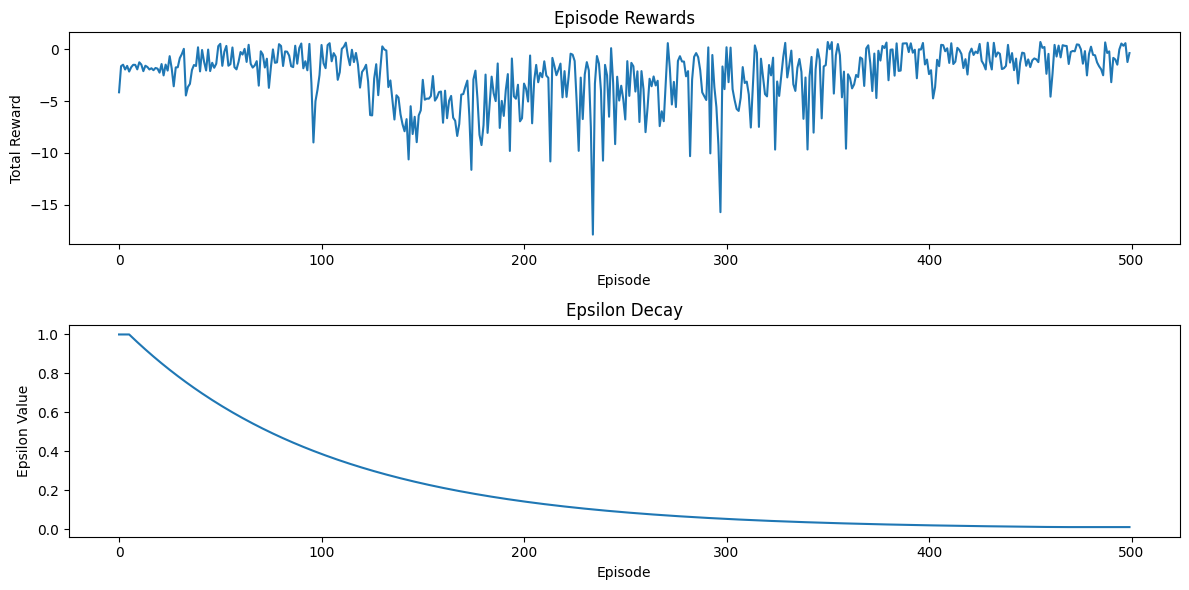

In [11]:
import numpy as np

# Normalise function
def normalise(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Hyperparameters
EPISODES = 500
MEMORY = 100000
INITIAL_INVENTORY = 21
INITIAL_INVENTORY_SCALED = 1
TIME_CONSTRAINT_FOR_EXECUTION = 11
A = 0.01

TRAINING = True
TRAIN_BOUNDARIES = False
LOAD_PRETRAINED_WEIGHTS = False

PANDL_REWARD = False
EGREEDY = "Binomial"
NN = "NN=6_NN"
OPTIMIZER = 'RMSprop'
FILENAME = f"DDQN{EPISODES}_NN_{EGREEDY}_A={A}_Actions={INITIAL_INVENTORY}_TimeConstr={TIME_CONSTRAINT_FOR_EXECUTION}_Opt={OPTIMIZER}_REW={str(PANDL_REWARD)}"
STATE_SIZE = 2
BATCH_SIZE = 64

# Define TIME_POINTS_FOR_EXECUTION
TIME_POINTS_FOR_EXECUTION = TIME_CONSTRAINT_FOR_EXECUTION

# Splitting the data
TRAIN_OBSERVATIONS = int(0.7 * len(data))
if TRAINING:
    DF = data.iloc[:TRAIN_OBSERVATIONS, ]
    REAL_TIME = 0
    END_TIME = len(DF)
else:
    DF = data.iloc[TRAIN_OBSERVATIONS:, ]
    REAL_TIME = TRAIN_OBSERVATIONS
    END_TIME = TRAIN_OBSERVATIONS + len(DF)
    EPISODES = 34

PRICES = np.array(DF['PRICE'].to_numpy())
PRICES = normalise(PRICES)

class Env:
    def __init__(self, initial_inventory, prices, time_constraint_for_execution, time_points_for_execution, real_time, end_time):
        self.state = State(np.zeros(STATE_SIZE), 0, initial_inventory)
        self.prices = prices
        self.time_constraint_for_execution = time_constraint_for_execution
        self.time_points_for_execution = time_points_for_execution
        self.real_time = real_time  # Use real_time argument
        self.end_time = end_time  # Use end_time argument
        self.initial_inventory = initial_inventory  # Store initial_inventory as an instance variable
    
    def reset_game(self):
        self.state = State(np.zeros(STATE_SIZE), 0, self.initial_inventory)  # Use self.initial_inventory here
        self.state.price = self.get_price()
        return self.state
    
    # Other methods remain unchanged...

    
    def step(self, action):
        current_price = self.get_price()
        price_penalty = max(0, current_price - self.state.price) * action
        
        reward = self.state.price * action - 2.5 * (action ** 2) - price_penalty
        
        self.state.time += 1
        self.real_time += 1
        
        return self.state, reward, self.is_done()
    
    def is_done(self):
        return self.state.time == self.time_constraint_for_execution
    
    def get_price(self):
        return self.prices[self.real_time]

class State:
    def __init__(self, data, time, inventory):
        self.data = data
        self.time = time
        self.inventory = inventory
        self.price = 0  # Initialize price to zero or any default value
        
    def state_as_list(self):
        return [self.time, self.inventory] + self.data.tolist()

    

class TWAP:
    def __init__(self, initial_inventory, time_points_for_execution):
        self.initial_inventory = initial_inventory
        self.time_points_for_execution = time_points_for_execution

    def act(self):
        return self.initial_inventory / self.time_points_for_execution

class DQNAgent:
    def __init__(self, state_size, action_size, TRAINING):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY)
        self.gamma = 0.99
        self.epsilon = 1.0 if TRAINING else 0.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()  # Add target_model
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state, time, time_constraint_for_execution):
        inventory = state[0][1]

        if time == (time_constraint_for_execution - 1 / (TIME_POINTS_FOR_EXECUTION - 1)):
            action = inventory
        elif inventory == 0:
            action = 0
        elif np.random.rand() <= self.epsilon:
            if EGREEDY == 'Binomial':
                n = inventory * INITIAL_INVENTORY
                p = 1 / (TIME_POINTS_FOR_EXECUTION - time)
                action = np.random.binomial(n, p) / INITIAL_INVENTORY
            elif EGREEDY == 'Uniform':
                action = random.randrange(self.action_size) / INITIAL_INVENTORY
        else:
            state_tensor = torch.FloatTensor(state)
            with torch.no_grad():
                act_values = self.model(state_tensor)
            action = np.argmax(act_values[0].numpy()) / (INITIAL_INVENTORY - 1)

        if action > inventory:
            action = inventory
        return round(action, 2)
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)
            
            # Normalize action to ensure it's within [0, 1]
            action = np.clip(action, 0.0, 1.0)
            
            # Find action index in action_range
            action_range = np.linspace(0, 1, self.action_size)
            action_index = np.abs(action_range - action).argmin()
            
            # Compute Q-value target
            target = self.model(state_tensor)
            
            if done:
                target[0, action_index] = reward
            else:
                with torch.no_grad():
                    t = self.target_model(next_state_tensor).max(1)[0]
                target[0, action_index] = reward + self.gamma * t.item()
            
            self.model.train()
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state_tensor), target)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_model(self, batch_size):
        self.target_model.load_state_dict(self.model.state_dict())

        # Check if there's enough data in memory to sample batch_size
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)
            
            # Normalize action to ensure it's within [0, 1]
            action = np.clip(action, 0.0, 1.0)
            
            # Find action index in action_range
            action_range = np.linspace(0, 1, self.action_size)
            action_index = np.abs(action_range - action).argmin()
            
            # Compute Q-value target
            target = self.model(state_tensor)
            
            if done:
                target[0, action_index] = reward
            else:
                with torch.no_grad():
                    t = self.target_model(next_state_tensor).max(1)[0]
                target[0, action_index] = reward + self.gamma * t.item()
            
            self.model.train()
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state_tensor), target)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)


# Training Loop
state_size = 4  # Adjusted state_size to match the length of state_as_list()
action_size = INITIAL_INVENTORY

agent = DQNAgent(state_size, action_size, TRAINING)
twap = TWAP(INITIAL_INVENTORY_SCALED, TIME_CONSTRAINT_FOR_EXECUTION)
env = Env(INITIAL_INVENTORY_SCALED, PRICES, TIME_CONSTRAINT_FOR_EXECUTION, TIME_POINTS_FOR_EXECUTION, REAL_TIME, END_TIME)

episode_rewards = []
epsilon_values = []

for episode in tqdm(range(EPISODES)):
    state = env.reset_game().state_as_list()
    state = np.reshape(state, [1, state_size])  # Reshape according to adjusted state_size

    total_reward = 0

    for time in range(TIME_POINTS_FOR_EXECUTION):
        action = agent.act(state, time, TIME_CONSTRAINT_FOR_EXECUTION)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state.state_as_list(), [1, state_size])
        total_reward += reward

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if TRAIN_BOUNDARIES:
            agent.replay(BATCH_SIZE)

        if done:
            episode_rewards.append(total_reward)
            epsilon_values.append(agent.epsilon)
            tqdm.write(f"Episode: {episode + 1}/{EPISODES}, Score: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
            break

    if not TRAIN_BOUNDARIES:
        agent.replay(BATCH_SIZE)

    agent.update_target_model(BATCH_SIZE)

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 1, 2)
plt.plot(epsilon_values)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.show()


In [12]:
len(data.columns)

21